El siguiente código forma parte de la Práctica 1 de la Asignatura ASDB/BDSA.

El modelo ha sido desarrollado en el artículo "An epidemiological model with voluntary quarantine strategies governed by evolutionary game dynamics" y cuyos autores son Marco A. Amaral, Marcelo M. de Oliveira y Marco A. Javarone (https://arxiv.org/abs/2008.05979)

In [241]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import seaborn as sns

In [242]:
# Modelo SIR Convencional

beta = 6		# Tasa de infección de los agentes
gamma = 0.6			# Tasa de recuperación

S0 = 0.99        			# Susceptibles iniciales (S)
I0 = 0.01        			# Infectados iniciales (I)
R0 = 0           			# Recuperados iniciales (R)

t0 = 0         			# Momento inicial (días)
tmax = 40       			# Tiempo máximo (días)
h = 0.01         			# Paso de integracíon (días)

In [243]:
def SIRmodel(y,t,beta,gamma):
    # función que devuelve la derivada temporal dy/dt
    s = y[0]
    i = y[1]

    #Ecuaciones Diferenciales Ordinarias del modelo SIR divididos en 5 subpoblaciones
    #S_n, subpoblación susceptible con comportamiento normal (S_n_dot es la derivada temporal de S_n)
    #S_q, subpoblación susceptible en cuarentena (S_q_dot es la derivada temporal de S_q) 
    #I_n, subpoblación infectada con comportamiento normal (I_n_dot es la derivada temporal de I_n)
    #Q_q, subpoblación infectada en cuarentena (I_q_dot es la derivada temporal de I_q) 
    #R, subpoblación recuperada (muertos o infectados) (R_dot es la derivada temporal de R) 

    s_d = -s*i*beta
    i_d = s*i*beta-i*gamma
    r_d = i*gamma

    dfdt = [s_d, i_d, r_d]
    return dfdt

In [244]:
# Creamos el vector de condiciones iniciales
y0 = [S0,I0,R0]

# Make time array for solution
tStop = tmax
tInc = h
t = np.arange(t0, tStop, tInc)

In [245]:
# Resolvemos la Ecuación Diferencial Ordinaria del SIR
psoln = odeint(SIRmodel, y0, t, args=(beta, gamma))

Text(0.5, 1.0, 'Evolución temporal de las subpoblaciones')

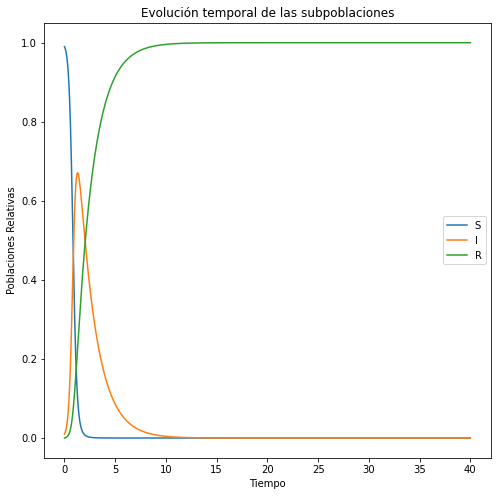

In [246]:
# Pintamos las subpoblaciones en función del tiempo
fig1 = plt.figure(1, figsize=(8, 8))
plt.plot(t, psoln[:, 0], label='S')
plt.plot(t, psoln[:, 1], label='I')
plt.plot(t, psoln[:, 2], label='R')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Poblaciones Relativas')
plt.title('Evolución temporal de las subpoblaciones')

# SIR + Game Theory

In [247]:
# Modelo SIR con estrategias de cuarentena (Q) y comportamiento normal (N)
# El comportamiento de las poblaciones completas se aproximan, con la aproximación de Campo Medio, 
# por las de un único agente y el efecto promedio de la población total sobre los agentes vecinos.
# Se considera que las poblaciones están homogéneamente mezcladas 
# Hay 5 subpoblaciones: Sq , Sn, In, Iq y R
# Parámetros

omega = 1          			# Coste de ponerse en cuarentena
delta = 1        			# Coste de ponerse enfermo/parametro del riesgo percibido por la enfermedad
betaq = 1       			# Tasa de infección de los agentes en cuarentena (cooperadores)
betan = 10
a = 0.1         	 	# Tasa de infección de los agentes en comportamiento normal (traidores)
betaa = a*(betan+betaq)/2   	            # Tasa de infección cruzada
gamma = 1        			# Tasa de recuperación
tau = 1         			# Escala de tiempo de cambio de estrategia (días) 
k = 1           			# Irracionalidad, factor que controla los fallos en la probabilidad de que un agente cambie de estrategia cometiendo un fallo (Regla de actualización de Fermi)     			
C0 = 0.5         			# Fracción inicial de agentes en cuarentena
D0 = 1 -C0         			# Fracción inicial de agentes con comportamiento normal
S0 = 0.99         			# Susceptibles iniciales (S)
I0 = 0.01       			# Infectados iniciales (I)
R0 =  0          			# Recuperados iniciales (R)
t0 =  0        			# Momento inicial (días)
tmax = 100        			# Tiempo máximo (días)
h =  0.01                   # Paso de integracíon (días)


In [248]:
def model(y, t, omega, delta, betaq, betan, betam, gamma, tau, k):
    # función que devuelve la derivada temporal dy/dt
    sn = y[0]
    sq = y[1]
    inn = y[2]
    iq = y[3]

    # Riesgo percibido por el agente en cuarentena
    piq = - omega
    # Riesgo percibido por el  agente con comportamiento normal
    pin = - delta*betan*inn

    f_piqpin = 1/(1+np.exp(-(pin-piq)/k))	 # Función de Fermi que regula la probabilidad de cambio de estrategia Theta(Pi_n,Pi_q)
    f_pinpiq = 1/(1+np.exp(-(piq-pin)/k))	 # Función de Fermi que regula la probabilidad de cambio de estrategia Theta(Pi_q,Pi_n)

    # Ecuaciones Maestras de la dinámica de un Juego Evolutivo Dinámico aproximado por Campo Medio.
    # Estas ecuaciones regulan las tasas de conversión de estrategia, esto es, 
    # Phi_S es la tasa a la que los agentes susceptibles con estrategia de cuarentena (S_q) se pasan a comportar normalmente (S_n)
    # Phi_I es la tasa a la que los agentes infectados con estrategia de cuarentena (I_q) se pasan a comportar normalmente (I_n)
    # Esta es la parte del modelo que responde a Teoría de Juegos Evolutiva con Aproximación de Campo Medio
    
    phisn = (sq*(sn+inn)*f_piqpin-sn*(sq+iq)*f_pinpiq)
    phiin = (iq*(sn+inn)*f_piqpin-inn*(sq+iq)*f_pinpiq)

    #Ecuaciones Diferenciales Ordinarias del modelo SIR divididos en 5 subpoblaciones
    #S_n, subpoblación susceptible con comportamiento normal (S_n_dot es la derivada temporal de S_n)
    #S_q, subpoblación susceptible en cuarentena (S_q_dot es la derivada temporal de S_q) 
    #I_n, subpoblación infectada con comportamiento normal (I_n_dot es la derivada temporal de I_n)
    #Q_q, subpoblación infectada en cuarentena (I_q_dot es la derivada temporal de I_q) 
    #R, subpoblación recuperada (muertos o infectados) (R_dot es la derivada temporal de R) 
    
    sndot = -sn*(betan*inn+betaa*iq)+tau*phisn
    sqdot = -sq*(betaa*inn+betaq*iq)-tau*phisn
    indot = sn*(betan*inn+betaa*iq)-gamma*inn+tau*phiin
    iqdot = sq*(betaa*inn+betaq*iq)-gamma*iq-tau*phiin
    rdot = gamma*(inn+iq)

    dfdt = [sndot, sqdot, indot, iqdot, rdot]
    return dfdt

In [249]:
# Inicialización de valores
sn0 = S0*D0
sq0 = S0*C0
in0 = I0*D0
iq0 = I0*C0
r0 = 0

In [250]:
# Agregamos todas las condiciones iniciales en un vector para pasárselo al resolvedor de Ecuaciones Diferenciales Ordinarias
y0 = [sn0, sq0, in0, iq0, r0]

# Make time array for solution
tStop = tmax
tInc = h
t = np.arange(0., tStop, tInc)

In [251]:
# Resolvemos la Ecuación Diferencial Ordinaria del SIR
psoln = odeint(model, y0, t, args=(omega, delta, betaq, betan, betaa, gamma, tau, k))

Text(0.5, 1.0, 'Evolución temporal de las subpoblaciones')

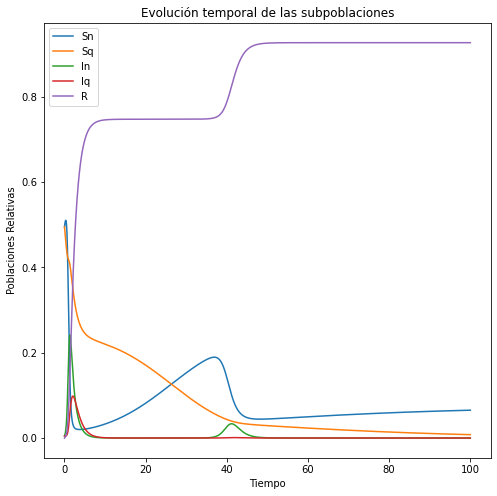

In [252]:
# Pintamos las subpoblaciones en función del tiempo
fig1 = plt.figure(1, figsize=(8, 8))
plt.plot(t, psoln[:, 0], label='Sn')
plt.plot(t, psoln[:, 1], label='Sq')
plt.plot(t, psoln[:, 2], label='In')
plt.plot(t, psoln[:, 3], label='Iq')
plt.plot(t, psoln[:, 4], label='R')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Poblaciones Relativas')
plt.title('Evolución temporal de las subpoblaciones')

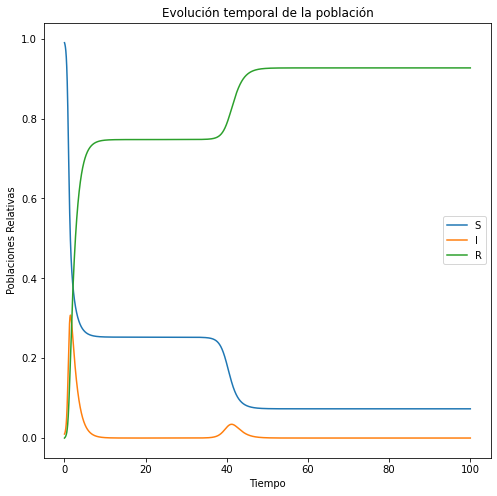

In [253]:
# Pintamos las poblaciones en función del tiempo
fig2 = plt.figure(2, figsize=(8, 8))
plt.plot(t, psoln[:, 0]+psoln[:, 1], label='S')
plt.plot(t, psoln[:, 2]+psoln[:, 3], label='I')
plt.plot(t, psoln[:, 4], label='R')
plt.xlabel('Tiempo')
plt.ylabel('Poblaciones Relativas')
plt.title('Evolución temporal de la población')
plt.legend()

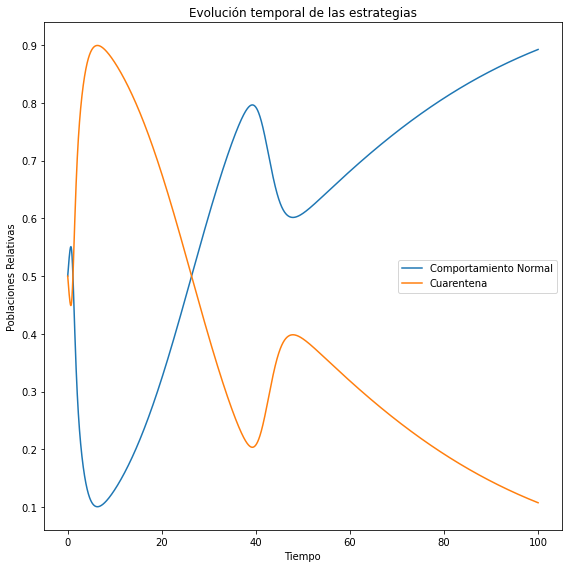

In [254]:
# Pintamos las estrategias en función del tiempo
fig3 = plt.figure(3, figsize=(8, 8))
plt.plot(t, (psoln[:, 0]+psoln[:, 2])/(psoln[:, 0]+psoln[:, 2]+psoln[:, 1]+psoln[:, 3]), label='Comportamiento Normal')
plt.plot(t, (psoln[:, 1]+psoln[:, 3])/(psoln[:, 0]+psoln[:, 2]+psoln[:, 1]+psoln[:, 3]), label='Cuarentena')
plt.xlabel('Tiempo')
plt.ylabel('Poblaciones Relativas')
plt.title('Evolución temporal de las estrategias')
plt.legend()

plt.tight_layout()
plt.show()

In [255]:
# sns.kdeplot( psoln[:, 0],psoln[:, 1])

In [256]:
# sns.kdeplot( psoln[:, 2],psoln[:, 3])